# **Part 1: NLP**

In [62]:
# Imports

import pandas as pd
import spacy
import matplotlib.pyplot as plt
import nltk

import tensorflow as tf
import numpy as np
import seaborn as sns

## Import Modeling Package
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from tensorflow.keras.models import Sequential



from sklearn.naive_bayes import MultinomialNB
# Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Increase column width
pd.set_option('display.max_colwidth', 300)

## Preprocessing

### Load functions

In [4]:
%load_ext autoreload
%autoreload 2

import AML_Belt_Functions as fn

### Load in the text classification dataframe

In [88]:
# Read Data
df = pd.read_csv ('data/part1-aml-belt-exam.csv')
df.head()

,author,text
0,Poe,additional information either on Monday or in the course of the
1,Poe,teeth. Not a speck on their surface—not a shade on their
2,Dickens,"“Harry? As soon as he had seen your friend here, safe in a coach with"
3,Poe,thought—to make sure that my vision had not deceived me—to calm
4,Poe,the flowers. No guile disguised the fervor of love which animated


In [9]:
df.shape

(3551, 2)

### Load the en_core_web_sm version of the spacy pipeline with the parser and ner disabled

In [8]:
# Load the en_core_web_sm version of the spacy pipeline with the parser and ner disabled
nlp_lite = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Print active components
nlp_lite.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

### Preprocess with spacy

#### Create a column with Tokenized text (no stopwords)

In [11]:
%%time

df['tokens']= fn.batch_preprocess_texts(df['text'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = False)

3551it [00:26, 133.85it/s] 

CPU times: total: 3.5 s
Wall time: 26.6 s


#### Create a column with Lemmatized text (no stopwords)

In [12]:
%%time

df['lemmas']= fn.batch_preprocess_texts(df['text'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = True)

3551it [00:25, 137.76it/s] 

CPU times: total: 3.08 s
Wall time: 25.8 s


#### Create a column with the tokens for each text joined together as a single string

In [13]:
# Join list of lemmas into a string with spaces between each lemma
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x))
df.head(3)

,author,text,tokens,lemmas,tokens-joined
0,Poe,additional information either on Monday or in the course of the,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course
1,Poe,teeth. Not a speck on their surface—not a shade on their,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade
2,Dickens,"“Harry? As soon as he had seen your friend here, safe in a coach with","[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach


#### Create a column with the lemmas for each text joined together as a single string

In [14]:
# Join list of lemmas into a string with spaces between each lemma
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head(3)

,author,text,tokens,lemmas,tokens-joined,lemmas-joined
0,Poe,additional information either on Monday or in the course of the,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course
1,Poe,teeth. Not a speck on their surface—not a shade on their,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade
2,Dickens,"“Harry? As soon as he had seen your friend here, safe in a coach with","[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach


## Perform group comparison EDA

### Define/separate two groups based on the source of the text (Poe or Dickens)

In [15]:
from wordcloud import WordCloud

In [16]:
# Create filters for Christie and Conan Doyle texts
filter_Poe = df['author'] == 'Poe'
filter_Dickens = df['author'] == 'Dickens'
filter_Poe.sum(), filter_Dickens.sum()

(2075, 1476)

### Create word clouds for each group using raw text

In [18]:
# Make a single giant string with entire group of Poe texts
Poe_text = " ".join( df.loc[filter_Poe, 'text'])
# Make a single giant string with entire group of Dickens texts
Dickens_text = " ".join( df.loc[filter_Dickens, 'text'])

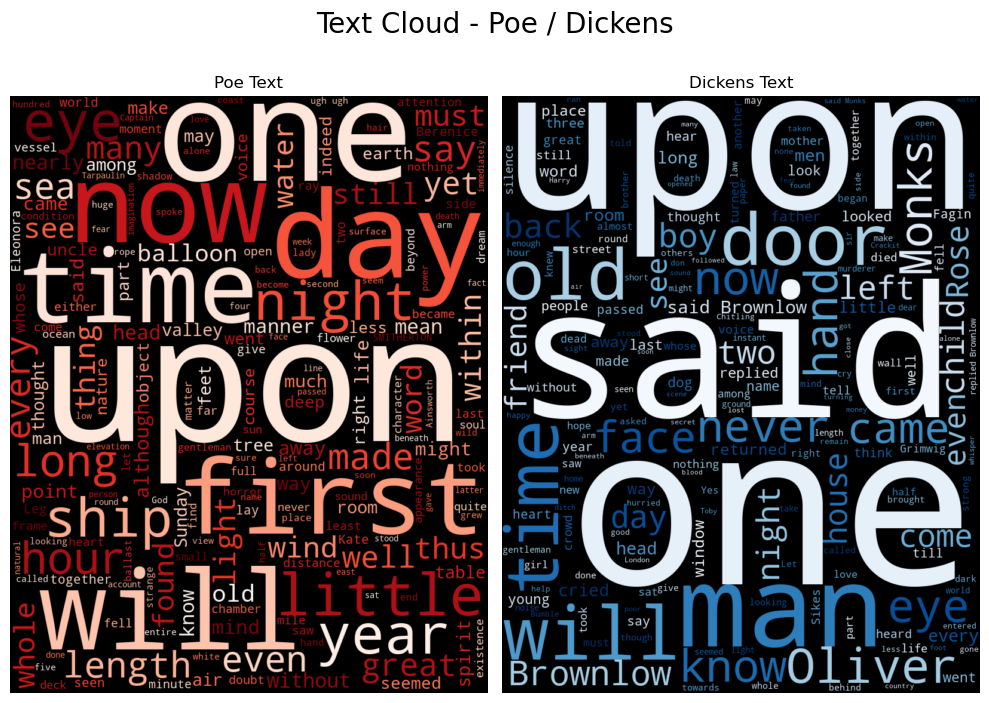

In [21]:
# Make word clouds of raw text
# Create an instance of a WordCloud and use the generate method
Poe_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 3, colormap="Reds",
                     ).generate(Poe_text)
Dickens_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 3,
                       colormap="Blues",
                      ).generate(Dickens_text)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(Poe_cloud, interpolation='bilinear')
axes[0].set_title("Poe Text")
axes[1].imshow(Dickens_cloud, interpolation='bilinear')
axes[1].set_title("Dickens Text")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Text Cloud - Poe / Dickens', fontsize=20, y=1.05);

### Create word clouds for each group using the joined lemmatized text

In [22]:
# Make a single giant string with entire group of Poe texts
Poe_lemmas = " ".join( df.loc[filter_Poe, 'lemmas-joined'])
# Make a single giant string with entire group of Dickens texts
Dickens_lemmas = " ".join( df.loc[filter_Dickens, 'lemmas-joined'])

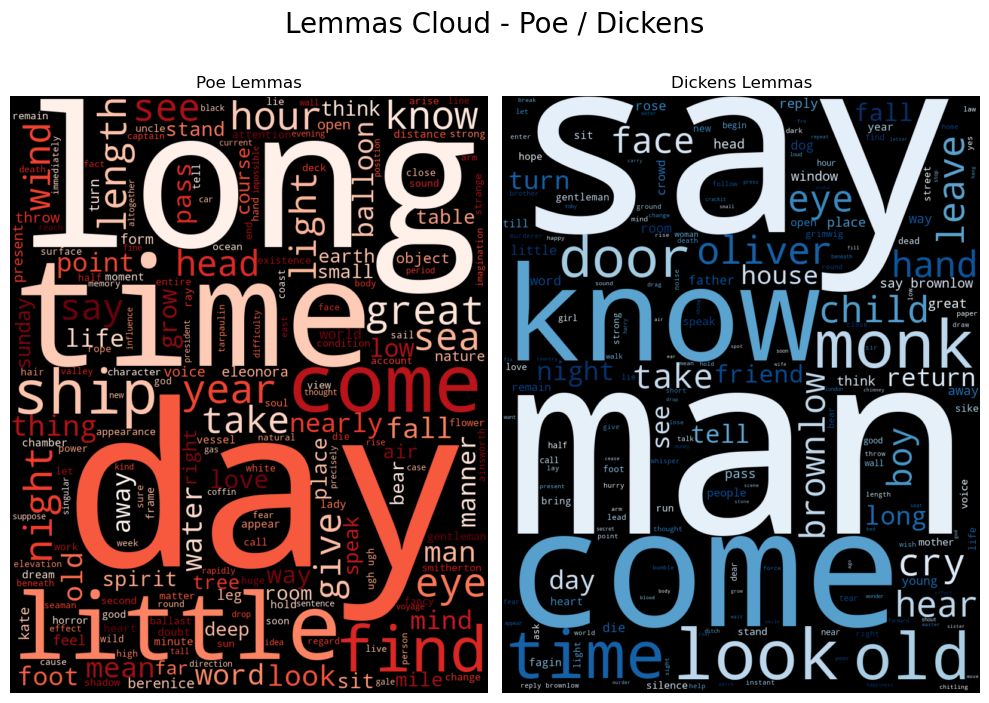

In [23]:
# Make word clouds of raw text
# Create an instance of a WordCloud and use the generate method
Poe_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 3, colormap="Reds",
                     ).generate(Poe_lemmas)
Dickens_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 3,
                       colormap="Blues",
                      ).generate(Dickens_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(Poe_cloud, interpolation='bilinear')
axes[0].set_title("Poe Lemmas")
axes[1].imshow(Dickens_cloud, interpolation='bilinear')
axes[1].set_title("Dickens Lemmas")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Lemmas Cloud - Poe / Dickens', fontsize=20, y=1.05);

### Display the top 20 most frequent bigrams of tokens (use the .raw_freq score) for both groups in a single dataframe

In [24]:
# Obtain single list of tokens from Poe texts
Poe_tokens_exploded_list = df.loc[filter_Poe, 'tokens'].explode().astype(str).to_list()
Poe_tokens_exploded_list[:5]

['additional', 'information', 'monday', 'course', 'teeth']

In [25]:
# Obtain single list of tokens from Doyle texts
Dickens_tokens_exploded_list = df.loc[filter_Dickens, 'tokens'].explode().astype(str).to_list()
Dickens_tokens_exploded_list[:5]

['harry', 'soon', 'seen', 'friend', 'safe']

In [26]:
# Test the function to find frequency values for bi-grams in Poe texts
bigram_Poe = fn.get_ngram_measures_finder(Poe_tokens_exploded_list, ngrams=2, top_n=20)
bigram_Poe

,Words,Raw Freq
0,"(mr., ainsworth)",0.000939
1,"(thousand, miles)",0.000835
2,"(guide, rope)",0.000730
3,"(valley, colored)",0.000730
4,"(colored, grass)",0.000626
5,"(captain, pratt)",0.000522
6,"(dubble, l.)",0.000522
7,"(king, pest)",0.000522
8,"(l., dee)",0.000522
9,"(mr., rumgudgeon)",0.000522


In [27]:
# Test the function to find frequency values for bi-grams in Dickens texts
bigram_Dickens = fn.get_ngram_measures_finder(Dickens_tokens_exploded_list, ngrams=2, top_n=20)
bigram_Dickens

,Words,Raw Freq
0,"(mr., brownlow)",0.008480
1,"(said, mr.)",0.004924
2,"(mr., grimwig)",0.001915
3,"(replied, mr.)",0.001778
4,"(mr., bumble)",0.001231
5,"(said, monks)",0.001094
6,"(mrs., maylie)",0.000957
7,"(old, gentleman)",0.000957
8,"(young, man)",0.000957
9,"(said, kags)",0.000821


In [28]:
# Combine low and high reviews score dfs and add a group name as multi-index
df_compare_bigrams = pd.concat(
    [bigram_Poe, bigram_Dickens],
    axis=1,
    keys=["Poe Texts", "Dickens Texts"],
)
df_compare_bigrams.head(20)

Poe Texts               Dickens Texts          
                  Words  Raw Freq             Words  Raw Freq
0      (mr., ainsworth)  0.000939   (mr., brownlow)  0.008480
1     (thousand, miles)  0.000835       (said, mr.)  0.004924
2         (guide, rope)  0.000730    (mr., grimwig)  0.001915
3     (valley, colored)  0.000730    (replied, mr.)  0.001778
4      (colored, grass)  0.000626     (mr., bumble)  0.001231
5      (captain, pratt)  0.000522     (said, monks)  0.001094
6          (dubble, l.)  0.000522    (mrs., maylie)  0.000957
7          (king, pest)  0.000522  (old, gentleman)  0.000957
8             (l., dee)  0.000522      (young, man)  0.000957
9     (mr., rumgudgeon)  0.000522      (said, kags)  0.000821
10       (25,000, feet)  0.000417   (mr., losberne)  0.000684
11     (doctor, dubble)  0.000417    (mrs., bumble)  0.000684
12             (ha, ha)  0.000417      (said, rose)  0.000684
13       (mr., osborne)  0.000417     (young, lady)  0.000684
14     (studding, sail)  0.000417  (looking, round)  0.000547
15  (uncle, rumgudgeon)  0.000417        (old, man)  0.000547
16  (yesterday, sunday)  0.000417    (asked, monks)  0.000410
17        (1000, years)  0.000313      (asked, mr.)  0.000410
18           (20, 1000)  0.000313    (began, think)  0.000410
19          (ana, pest)  0.000313      (cried, boy)  0.000410

## Text Classification - Machine Learning

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551 entries, 0 to 3550
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         3551 non-null   object
 1   text           3551 non-null   object
 2   tokens         3551 non-null   object
 3   lemmas         3551 non-null   object
 4   tokens-joined  3551 non-null   object
 5   lemmas-joined  3551 non-null   object
dtypes: object(6)
memory usage: 166.6+ KB


In [30]:
df['author'].value_counts()

Poe        2075
Dickens    1476
Name: author, dtype: int64

In [31]:
# Define X and y
X = df['text']
y = df['author']

In [32]:
# tts
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)

In [33]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf', MultinomialNB())])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer()), ('clf', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       0.94      0.97      0.96      1132
         Poe       0.98      0.95      0.97      1531

    accuracy                           0.96      2663
   macro avg       0.96      0.96      0.96      2663
weighted avg       0.96      0.96      0.96      2663



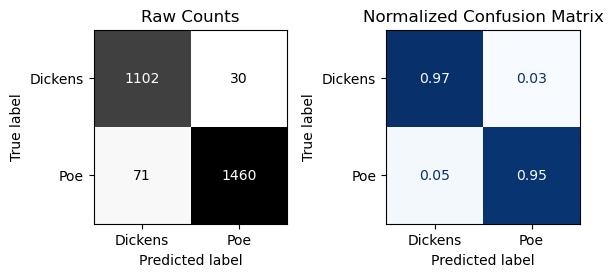


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       0.78      0.85      0.82       344
         Poe       0.90      0.85      0.88       544

    accuracy                           0.85       888
   macro avg       0.84      0.85      0.85       888
weighted avg       0.85      0.85      0.85       888



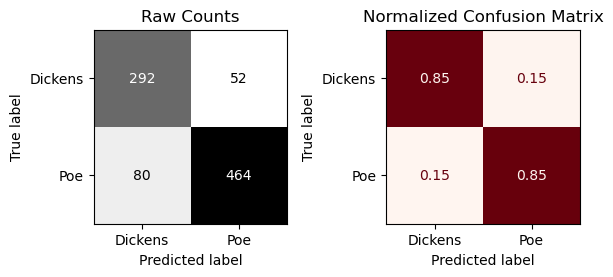

In [34]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Evaluate
fn.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

### **The high accuracy on the training data (96%) compared to the lower accuracy on the testing data (85%) indicates that this model might be overfitting.**

In [92]:
# Save this model pipeline to a Models folder in your repo as a joblib file
import os

os.makedirs('models/' ,exist_ok =True)

In [93]:
import joblib
fpath_model = "models/nb_classifierexam.joblib"
joblib.dump(clf_pipe, fpath_model)

['models/nb_classifierexam.joblib']

## Text Classification - Deep NLP

### Prepare tensorflow datasets for a train/val/test split

In [37]:
from sklearn.preprocessing import LabelEncoder

# Instansiate label encoder
encoder = LabelEncoder()

y_enc = encoder.fit_transform(y)
y_enc

array([1, 1, 0, ..., 1, 0, 0])

In [38]:
# Original Class names saved as .classes_
classes = encoder.classes_
classes

array(['Dickens', 'Poe'], dtype=object)

In [39]:
# Can inverse-transform 
encoder.inverse_transform([0,1])

array(['Dickens', 'Poe'], dtype=object)

In [40]:
# Use a batch size of 32
BATCH_SIZE =32

### Select a sequence length appropriate for the dataset's text

In [41]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()

,author,text,tokens,lemmas,tokens-joined,lemmas-joined,sequence_length
0,Poe,additional information either on Monday or in the course of the,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course,17
1,Poe,teeth. Not a speck on their surface—not a shade on their,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade,17
2,Dickens,"“Harry? As soon as he had seen your friend here, safe in a coach with","[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach,15
3,Poe,thought—to make sure that my vision had not deceived me—to calm,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]",thought sure vision deceived calm,think sure vision deceive calm,17
4,Poe,the flowers. No guile disguised the fervor of love which animated,"[flowers, guile, disguised, fervor, love, animated]","[flower, guile, disguise, fervor, love, animate]",flowers guile disguised fervor love animated,flower guile disguise fervor love animate,17


In [42]:
df['sequence_length'].describe()

count    3551.000000
mean       14.643199
std         3.129817
min         6.000000
25%        12.000000
50%        15.000000
75%        17.000000
max        22.000000
Name: sequence_length, dtype: float64

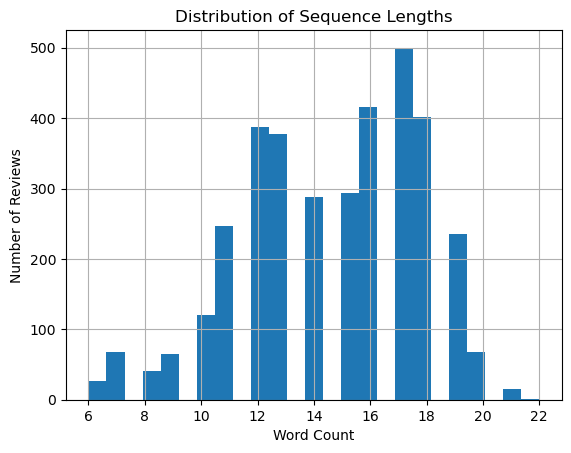

In [43]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

**The range of sequence length is from 6 to 22**

**Lets take maximum sequence length as 30**

### Prepare the dataset for modeling

In [44]:
print(X)

0               additional information either on Monday or in the course of the
1                      teeth. Not a speck on their surface—not a shade on their
2         “Harry? As soon as he had seen your friend here, safe in a coach with
3               thought—to make sure that my vision had not deceived me—to calm
4             the flowers. No guile disguised the fervor of love which animated
                                         ...                                   
3546            condition of shadow and doubt, appertaining to the present, and
3547          I left it for ever for the vanities and the turbulent triumphs of
3548              soul, to the most intense and painful meditation—she, roaming
3549    upon the scenes of the past, resolved to amend it in some new sphere of
3550    distinctness, looked towards his counsel, in mute appeal that he would,
Name: text, Length: 3551, dtype: object


In [45]:
print(y_enc)

[1 1 0 ... 1 0 0]


#### Convert to a Dataset object and Perform the Train, Test, Validation Split

In [46]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y_enc))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [47]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [48]:
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	2485 samples 	(78 batches)
    - val:  	710 samples 	(23 batches)
    - test: 	356 samples 	(12 batches)


In [49]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [50]:
# Confirm len of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(78, 23, 12)

### Build, fit, and evaluate a binary classification sequence model

#### Include a Keras TextVectorization as a layer in your model

In [51]:
SEQUENCE_LENGTH = 40
# Create text Vectorization layer
text_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [52]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y_enc: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'The broad sky seemed on fire. Rising into the air with showers of',
       b'glean nothing from their faces; they might as well have been of stone.',
       b'As the villain folded his arms tight together, and muttered curses on',
       b'      the trailing of the buoys materially impeded our progress, and we',
       b'fixed upon the floor; seeing this, he immediately resumed:',
       b'\xe2\x80\x9cEspecially, when the exclusive young man has got a friend stopping',
       b'born, and accidentally encountered by you, when your suspicions were',
       b'      paw, making strenuous efforts to accomplish the ditty.',
       b'      presence, sighing upon me in the evening winds, or filling the',
       b'      cryptogamous _fungus_ that emits an intense phosphorescence.',
       b'      MYSELF. (Hurriedly.) \xe2\x80\x9cCaptain Pratt, you must come and spend the',
       b'two or three months, he contented himself with hinting that

In [54]:
# Train (adapt on training text data))
text_vectorizer.adapt(ds_texts)
text_vectorizer.vocabulary_size()

5862

In [55]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = text_vectorizer.vocabulary_size()
VOCAB_SIZE

5862

#### Use 100 as the embedding dimension/size

In [56]:
EMBED_DIM = 100

In [57]:
print(f'VOCAB_SIZE is {VOCAB_SIZE}')
print(f'SEQUENCE_LENGTH is {SEQUENCE_LENGTH}')
print(f'EMBED_DIM is {EMBED_DIM}')

VOCAB_SIZE is 5862
SEQUENCE_LENGTH is 40
EMBED_DIM is 100


#### Use a bidirectional GRU

In [83]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    
    # Add a pooling layer 
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 40)               0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 40, 100)           586200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 40, 128)          63744     
 nal)                                                            
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                      

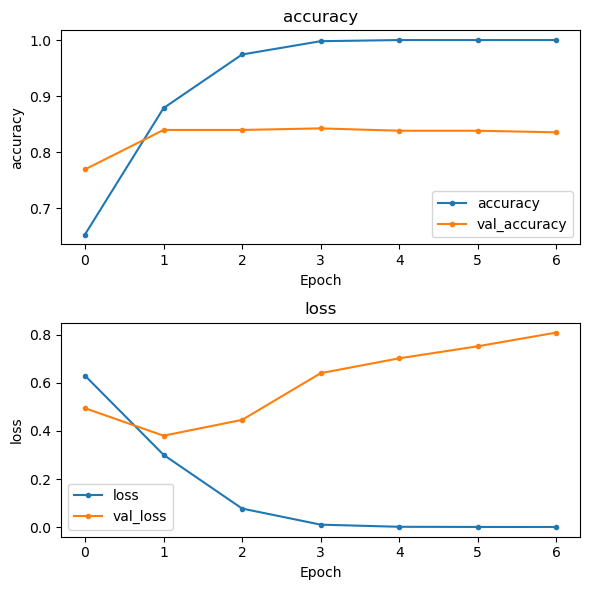


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       1.00      1.00      1.00      1482

    accuracy                           1.00      2485
   macro avg       1.00      1.00      1.00      2485
weighted avg       1.00      1.00      1.00      2485



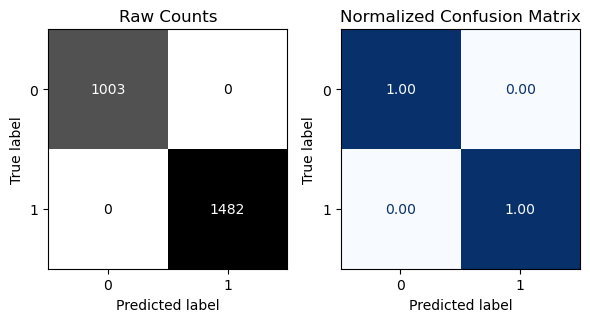


- Evaluating Training Data:
78/78 [==============================] - 1s 7ms/step - loss: 3.5024e-04 - accuracy: 1.0000
{'loss': 0.0003502414911054075, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       166
           1       0.83      0.85      0.84       190

    accuracy                           0.82       356
   macro avg       0.82      0.82      0.82       356
weighted avg       0.82      0.82      0.82       356



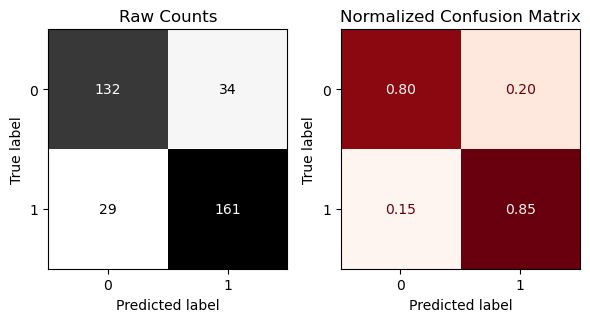


- Evaluating Test Data:
12/12 [==============================] - 0s 6ms/step - loss: 0.8546 - accuracy: 0.8230
{'loss': 0.854610800743103, 'accuracy': 0.8230336904525757}


In [76]:
# Build the model
model = build_gru_model_bi_pool(text_vectorizer)

# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

### **The bidirectional-GRU model, indicates a significant overfitting issue; has perfectly memorized the training data, which is why it achieves 100% accuracy. However, this memorization does not generalize well to new, unseen data, as evidenced by the drop to 82% accuracy on the testing data.**

##### Add recurrent_dropout and dropout

In [84]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, recurrent_dropout=.3, dropout=.3, return_sequences = True)))
    
    # Add a pooling layer 
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 40)               0         
 torization)                                                     
                                                                 
 embedding_8 (Embedding)     (None, 40, 100)           586200    
                                                                 
 bidirectional_4 (Bidirectio  (None, 40, 128)          63744     
 nal)                                                            
                                                                 
 global_max_pooling1d_8 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                      

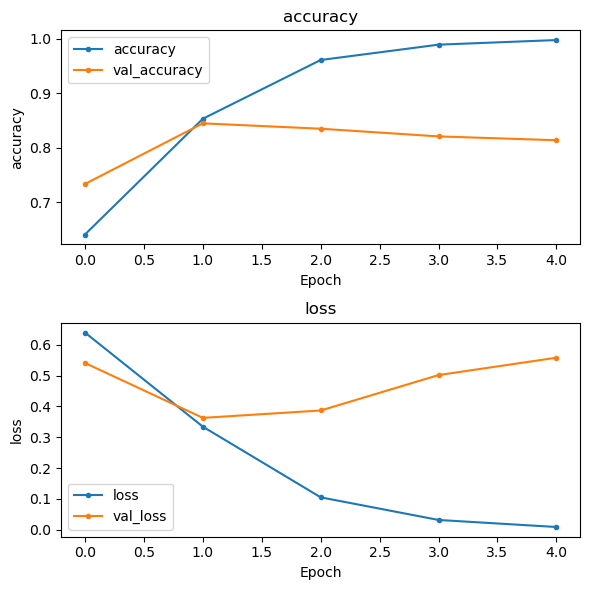


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       1.00      1.00      1.00      1482

    accuracy                           1.00      2485
   macro avg       1.00      1.00      1.00      2485
weighted avg       1.00      1.00      1.00      2485



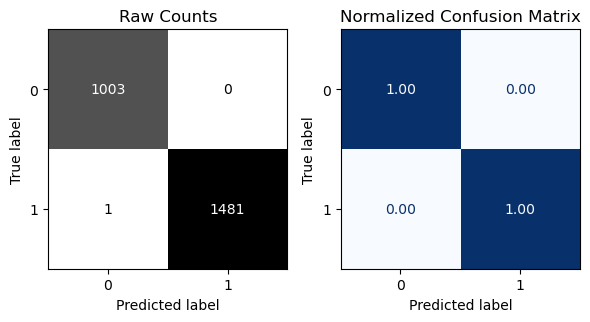


- Evaluating Training Data:
78/78 [==============================] - 1s 9ms/step - loss: 0.0048 - accuracy: 0.9996
{'loss': 0.004838953725993633, 'accuracy': 0.9995976090431213}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       166
           1       0.84      0.84      0.84       190

    accuracy                           0.83       356
   macro avg       0.83      0.83      0.83       356
weighted avg       0.83      0.83      0.83       356



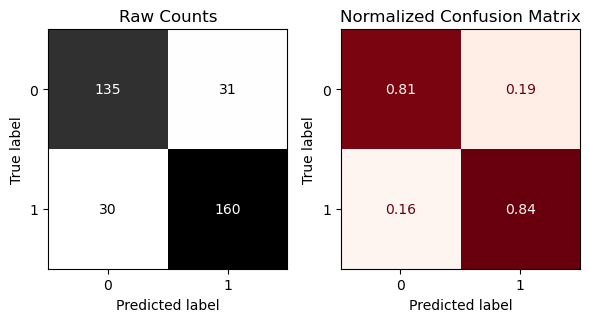


- Evaluating Test Data:
12/12 [==============================] - 0s 9ms/step - loss: 0.5874 - accuracy: 0.8287
{'loss': 0.5873927474021912, 'accuracy': 0.8286516666412354}


In [80]:
# Build the model
model = build_gru_model_bi_pool(text_vectorizer)

# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

##### More Units

In [85]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, recurrent_dropout=.3, dropout=.3, return_sequences = True)))
    
    # Add a pooling layer 
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 40)               0         
 torization)                                                     
                                                                 
 embedding_9 (Embedding)     (None, 40, 100)           586200    
                                                                 
 bidirectional_5 (Bidirectio  (None, 40, 256)          176640    
 nal)                                                            
                                                                 
 global_max_pooling1d_9 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 2)                 514       
                                                      

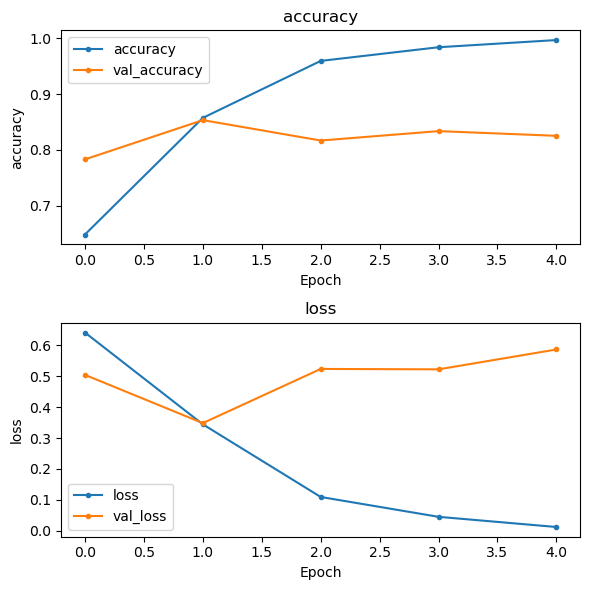


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       1.00      1.00      1.00      1482

    accuracy                           1.00      2485
   macro avg       1.00      1.00      1.00      2485
weighted avg       1.00      1.00      1.00      2485



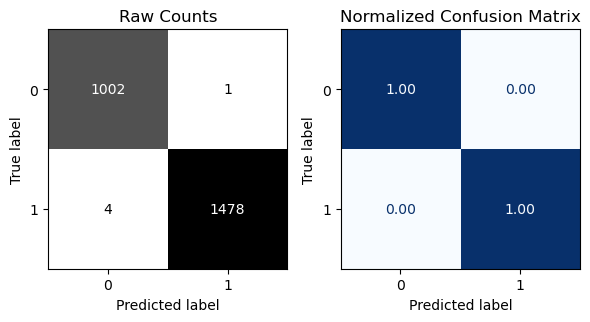


- Evaluating Training Data:
78/78 [==============================] - 3s 32ms/step - loss: 0.0074 - accuracy: 0.9980
{'loss': 0.007390064653009176, 'accuracy': 0.9979879260063171}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       166
           1       0.80      0.91      0.85       190

    accuracy                           0.83       356
   macro avg       0.84      0.83      0.83       356
weighted avg       0.84      0.83      0.83       356



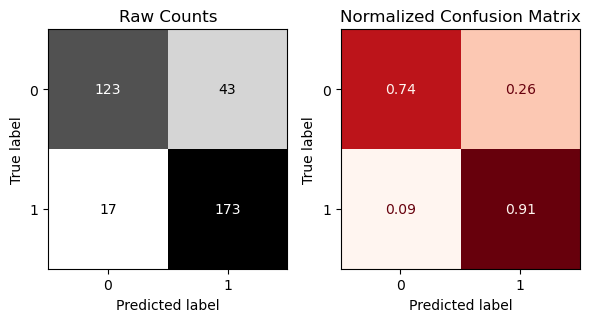


- Evaluating Test Data:
12/12 [==============================] - 0s 31ms/step - loss: 0.5358 - accuracy: 0.8315
{'loss': 0.5357979536056519, 'accuracy': 0.8314606547355652}


In [82]:
# Build the model
model = build_gru_model_bi_pool(text_vectorizer)

# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

# **Both models are overfitting**

## **Neural networks typically perform better with large datasets.**

## **In summary, the higher accuracy of the ML model could indicate that it’s more suited to the problem or that your neural network might need further tuning or a larger dataset to show its full potential.**

### Save your model to a Models folder in your repo in the SavedModel format (save_format='tf')

In [94]:
fpath_model = "models/gru"
#tf.keras.models.save_model(model, fpath_model)
gru_model.save(fpath_model, save_format='tf')

INFO:tensorflow:Assets written to: models/gru\assets
